# **<center>SQL interview Preparation</center>**
* **6 important SQL questions for goods handson including joins, filter, cte and windows function**



In [60]:
#  Installing db-sqlite3 
# !pip install db-sqlite3

In [61]:
import pandas as pd
import sqlite3
from datetime import date

In [62]:
#connecting and creating with the database.
db = sqlite3.connect("testing.db")
db.execute("drop table if exists results")

## **1. Tournament Winners**
* **Write a SQL query to find the winner in each group**
* *The winner in each group is the player who scored the maximum total points within the group. In the case of a tie, the lowest player_id wins.* 

In [63]:
# Create table
try:
  db.execute("""
  create table players(
    player_id int,
    group_id int
    )""")
  db.execute("""
  create table matches(
    match_id int,
    first_player int,
    second_player int,
    first_score int,
    second_score int
    )""")
except:
  print("Already table existed !!")
# Insert values
input_players = [
"insert into players values (15,1);",
"insert into players values (25,1);",
"insert into players values (30,1);",
"insert into players values (45,1);",
"insert into players values (10,2);",
"insert into players values (35,2);",
"insert into players values (50,2);",
"insert into players values (20,3);",
"insert into players values (40,3);"
]
for i in input_players:
  db.execute(i)
  db.commit()


input_matches = [
"insert into matches values (1,15,45,3,0);",
"insert into matches values (2,30,25,1,2);",
"insert into matches values (3,30,15,2,0);",
"insert into matches values (4,40,20,5,2);",
"insert into matches values (5,35,50,1,1);"
]
for i in input_matches:
  db.execute(i)
  db.commit()

In [64]:
qry = """
select * from players;
"""
pd.read_sql_query(qry, db)

,player_id,group_id
0,15,1
1,25,1
2,30,1
3,45,1
4,10,2
5,35,2
6,50,2
7,20,3
8,40,3


In [65]:
qry = """
select * from matches;
"""
pd.read_sql_query(qry, db)

,match_id,first_player,second_player,first_score,second_score
0,1,15,45,3,0
1,2,30,25,1,2
2,3,30,15,2,0
3,4,40,20,5,2
4,5,35,50,1,1


**Expected Output:**

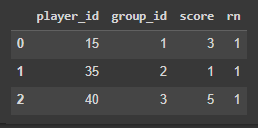

In [66]:
qry = """
with player_score as(
select 
first_player as player_id,
first_score as score
from matches
union all
select 
second_player as player_id,
second_score as score
from matches
),
final_score as(
select 
ps.player_id,
p.group_id,
sum(ps.score) as score
from player_score ps
inner join players as p
on ps.player_id=p.player_id
group by 1,2
),
final_ranking as(
select 
*,
rank() over(partition by group_id order by score desc, player_id asc) as rn
from final_score
)
select 
* 
from final_ranking 
where rn =1
"""
pd.read_sql_query(qry, db)

,player_id,group_id,score,rn
0,15,1,3,1
1,35,2,1,1
2,40,3,5,1


## **2. Market Analysis**
* Write an SQL query to find for each seller, whether the brand of the second item (by date) they sold is their favoruite
* If a seller sold less than two items, report the answer for that seller as no. 

In [67]:
# Create table
try:
  db.execute("""
  create table users (
    user_id int,
    join_date date,
    favorite_brand varchar(50));
  """)

  db.execute("""
  create table orders (
    order_id int,
    order_date date,
    item_id int,
    buyer_id int,
    seller_id int);
  """)

  db.execute("""
  create table items(
    item_id int,
    item_brand varchar(50));
  """)
except:
  print("Already table existed !!")

# Insert values
input_users = [ """
insert into users values 
(1,'2019-01-01','Lenovo'),
(2,'2019-02-09','Samsung'),
(3,'2019-01-19','LG'),
(4,'2019-05-21','HP');
"""]
input_items = [ """
insert into items values 
(1,'Samsung'),
(2,'Lenovo'),
(3,'LG'),
(4,'HP');
"""]
input_orders = [ """
insert into orders values 
(1,'2019-08-01',4,1,2),
(2,'2019-08-02',2,1,3),
(3,'2019-08-03',3,2,3),
(4,'2019-08-04',1,4,2),
(5,'2019-08-04',1,3,4),
(6,'2019-08-05',2,2,4);
"""]
db.execute(input_users[0])
db.execute(input_items[0])
db.execute(input_orders[0])

In [68]:
qry = """
select * from users;
"""
pd.read_sql_query(qry, db)

,user_id,join_date,favorite_brand
0,1,2019-01-01,Lenovo
1,2,2019-02-09,Samsung
2,3,2019-01-19,LG
3,4,2019-05-21,HP


In [69]:
qry = """
select * from items;
"""
pd.read_sql_query(qry, db)

,item_id,item_brand
0,1,Samsung
1,2,Lenovo
2,3,LG
3,4,HP


In [70]:
qry = """
select * from orders;
"""
pd.read_sql_query(qry, db)

,order_id,order_date,item_id,buyer_id,seller_id
0,1,2019-08-01,4,1,2
1,2,2019-08-02,2,1,3
2,3,2019-08-03,3,2,3
3,4,2019-08-04,1,4,2
4,5,2019-08-04,1,3,4
5,6,2019-08-05,2,2,4


**Expected Output:**

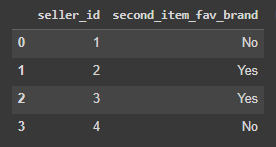

In [71]:
qry = """
with rnk_orders as(
select 
*,
rank() over(partition by seller_id order by order_date asc) as rn 
from orders
),
second_cte as(
select
u.user_id, 
ro.*,
i.item_brand,
u.favorite_brand,
case when i.item_brand=u.favorite_brand then 'Yes' else 'No' end as second_item_fav_brand
from users u
left join rnk_orders ro on ro.seller_id=u.user_id and rn=2
left join items i on i.item_id=ro.item_id 
)
select 
user_id as seller_id,
second_item_fav_brand
from second_cte
"""
pd.read_sql_query(qry, db)

,seller_id,second_item_fav_brand
0,1,No
1,2,Yes
2,3,Yes
3,4,No


## **3. Tricky SQL Question**

In [72]:
# Create table
try:
  db.execute("""
  create table tasks (
    date_value date,
    state varchar(10)
    );
  """)
except:
  print("Already table existed !!")

# Insert values
input = ["""
insert into tasks  values 
('2019-01-01','success'),
('2019-01-02','success'),
('2019-01-03','success'),
('2019-01-04','fail'),
('2019-01-05','fail'),
('2019-01-06','success')
"""]
for i in input:
  db.execute(i)
  db.commit()

In [73]:
qry = """
select 
* 
from tasks
"""
pd.read_sql_query(qry, db)     


,date_value,state
0,2019-01-01,success
1,2019-01-02,success
2,2019-01-03,success
3,2019-01-04,fail
4,2019-01-05,fail
5,2019-01-06,success


**Expected Output:**

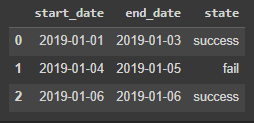

In [74]:
qry = """
with all_dates as(
select 
*,
row_number() over(partition by state order by date_value) as rn,
DATE(date_value,cast(row_number() over(partition by state order by date_value)*-1 as varchar(20)) || ' days') as group_date
from tasks
order by date_value
)
select
min(date_value) as start_date,
max(date_value) as end_date,
state
from all_dates
group by group_date,state
order by start_date
"""
pd.read_sql_query(qry, db)     


,start_date,end_date,state
0,2019-01-01,2019-01-03,success
1,2019-01-04,2019-01-05,fail
2,2019-01-06,2019-01-06,success


## **4. User Purchase Platform**
* The table logs the spendings history of users that make purchases from an online shopping website which has a desktop and a mobile application
* **Write a SQL query to find the total number of users and the total amount spent using mobile only, desktop only and both mobile and desktop together for each date?**

In [75]:
# Create table
try:
  db.execute("""
  create table spending(
    user_id int,
    spend_date date,
    platform varchar(10),
    amount int
    );
  """)
except:
  print("Already table existed !!")

# Insert values
input = ["""
insert into spending values
(1,'2019-07-01','mobile',100),
(1,'2019-07-01','desktop',100),
(2,'2019-07-01','mobile',100),
(2,'2019-07-02','mobile',100),
(3,'2019-07-01','desktop',100),
(3,'2019-07-02','desktop',100);
"""]
for i in input:
  db.execute(i)
  db.commit()

In [76]:
qry = """
select 
* 
from spending
"""
pd.read_sql_query(qry, db)     


,user_id,spend_date,platform,amount
0,1,2019-07-01,mobile,100
1,1,2019-07-01,desktop,100
2,2,2019-07-01,mobile,100
3,2,2019-07-02,mobile,100
4,3,2019-07-01,desktop,100
5,3,2019-07-02,desktop,100


**Expected Output:**

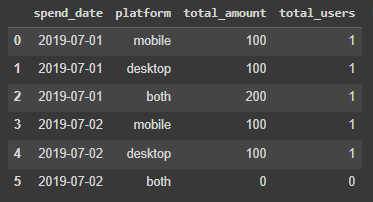

In [77]:
qry = """
with all_spend as(
select 
spend_date,
user_id,
max(platform) as platform,
sum(amount) as amount 
from spending
group by spend_date,user_id
having count(distinct platform)=1
union all
select 
spend_date,
user_id,
'both' as platform,
sum(amount) as amount 
from spending
group by spend_date,user_id
having count(distinct platform)=2
union all
select 
distinct spend_date,
null as user_id,
'both' as platform,
0 as amount 
from spending
)
select 
spend_date,
platform,
sum(amount) as total_amount,
count(distinct user_id) as total_users
from all_spend
group by 1,2
order by 1,2 desc
"""
pd.read_sql_query(qry, db)     


,spend_date,platform,total_amount,total_users
0,2019-07-01,mobile,100,1
1,2019-07-01,desktop,100,1
2,2019-07-01,both,200,1
3,2019-07-02,mobile,100,1
4,2019-07-02,desktop,100,1
5,2019-07-02,both,0,0


## **5. Recurvsive CTE**
* It means cte running in loop. CTE will call itself till the break point
* Example:
  ```
  with cte_numbers as(
    select 1 as num --anchor query
    union all
    select num + 1 --recursive query
    from cte_numbers
    where num<6 --filter to stop the recursion
  )
  select num from cte_numbers
  ```

In [78]:
qry = """
with cte_numbers as(
  select 1 as num --anchor query
  union all
  select num +1 --recursive query
  from cte_numbers
  where num<6 --filter to stop the recursion
)
select num from cte_numbers
"""
pd.read_sql_query(qry,db)

,num
0,1
1,2
2,3
3,4
4,5
5,6


* **Total sales by year**

In [79]:
# Create table
try:
  db.execute("""
    create table sales (
    product_id int,
    period_start date,
    period_end date,
    average_daily_sales int
    );
  """)
except:
  print("Already table existed !!")

# Insert values
input = ["""
insert into sales values
(1,'2019-01-25','2019-02-28',100),
(2,'2018-12-01','2020-01-01',10),
(3,'2019-12-01','2020-01-31',1);
"""]
for i in input:
  db.execute(i)
  db.commit()

In [80]:
qry = """
select 
* 
from sales
"""
pd.read_sql_query(qry, db).head()     


,product_id,period_start,period_end,average_daily_sales
0,1,2019-01-25,2019-02-28,100
1,2,2018-12-01,2020-01-01,10
2,3,2019-12-01,2020-01-31,1


**Expected Output:**

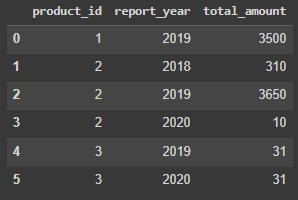

In [81]:
qry = """
with r_cte as (
select min(period_start) as dates, --anchor query
max(period_end) as max_date
from sales
union all
select 
date(dates, '+1 days') as dates, max_date
from r_cte
where  dates < max_Date
)
select 
product_id,
strftime('%Y',dates) as report_year,
sum(average_daily_sales) as total_amount 
from r_cte r
inner join sales s
on dates between period_start and period_end
group by 1,2
order by product_id, dates
"""
pd.read_sql_query(qry, db)

,product_id,report_year,total_amount
0,1,2019,3500
1,2,2018,310
2,2,2019,3650
3,2,2020,10
4,3,2019,31
5,3,2020,31


## **6. Recommendation System**
* Basket Analysis
* Recommendation System: Based on product pairs most commonly purchased together

In [82]:
# Create table
try:
  db.execute("""
    create table orders_1(
    order_id int,
    customer_id int,
    product_id int
    );
  """)
  db.execute("""
    create table products_1(
    id int,
    name varchar(10)
    );
  """)

except:
  print("Already table existed !!")
  
# Insert values
input_orders_1 = ["""
insert into orders_1 VALUES 
(1, 1, 1),
(1, 1, 2),
(1, 1, 3),
(2, 2, 1),
(2, 2, 2),
(2, 2, 4),
(3, 1, 5);
"""]
for i in input_orders_1:
  db.execute(i)
  db.commit()

input_products_1 = ["""
insert into products_1 VALUES 
(1, 'A'),
(2, 'B'),
(3, 'C'),
(4, 'D'),
(5, 'E');
"""]
for i in input_products_1:
  db.execute(i)
  db.commit()

In [83]:
qry = """
select 
* 
from orders_1
"""
pd.read_sql_query(qry, db)     


,order_id,customer_id,product_id
0,1,1,1
1,1,1,2
2,1,1,3
3,2,2,1
4,2,2,2
5,2,2,4
6,3,1,5


In [84]:
qry = """
select 
* 
from products_1
"""
pd.read_sql_query(qry, db)     


,id,name
0,1,A
1,2,B
2,3,C
3,4,D
4,5,E


**Expected Output:**

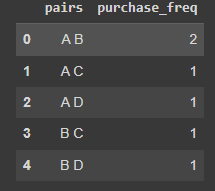

In [85]:
qry = """
with cte1 as (
select 
pr1.name as p1,
pr2.name as  p2,
count(1) as purchase_freq
from orders_1 o1
inner join orders_1 o2 on o1.order_id = o2.order_id
inner join products_1 pr1 on pr1.id = o1.product_id
inner join products_1 pr2 on pr2.id = o2.product_id
where o1.product_id<o2.product_id
group by 1,2
)
select 
p1||' '||p2 as pairs, 
purchase_freq
from cte1 
"""
pd.read_sql_query(qry, db)     


,pairs,purchase_freq
0,A B,2
1,A C,1
2,A D,1
3,B C,1
4,B D,1


**Source:**
* https://www.youtube.com/playlist?list=PLBTZqjSKn0IeKBQDjLmzisazhqQy4iGkb

# **<center>THE END</center>**